<a href="https://colab.research.google.com/github/hoa-kidnav/Responsive-Login-Form/blob/master/Welcome_To_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model.eval()

In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
%mkdir mobilenetv2

In [ ]:
%cd mobilenetv2

/content/drive/MyDrive/mobilenetv2


In [ ]:
# Download an example image from the pytorch website
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [ ]:

# Download an example image from the pytorch website
import urllib
url, filename = ("https://upload.wikimedia.org/wikipedia/commons/4/4d/Cat_November_2010-1a.jpg", "cat.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

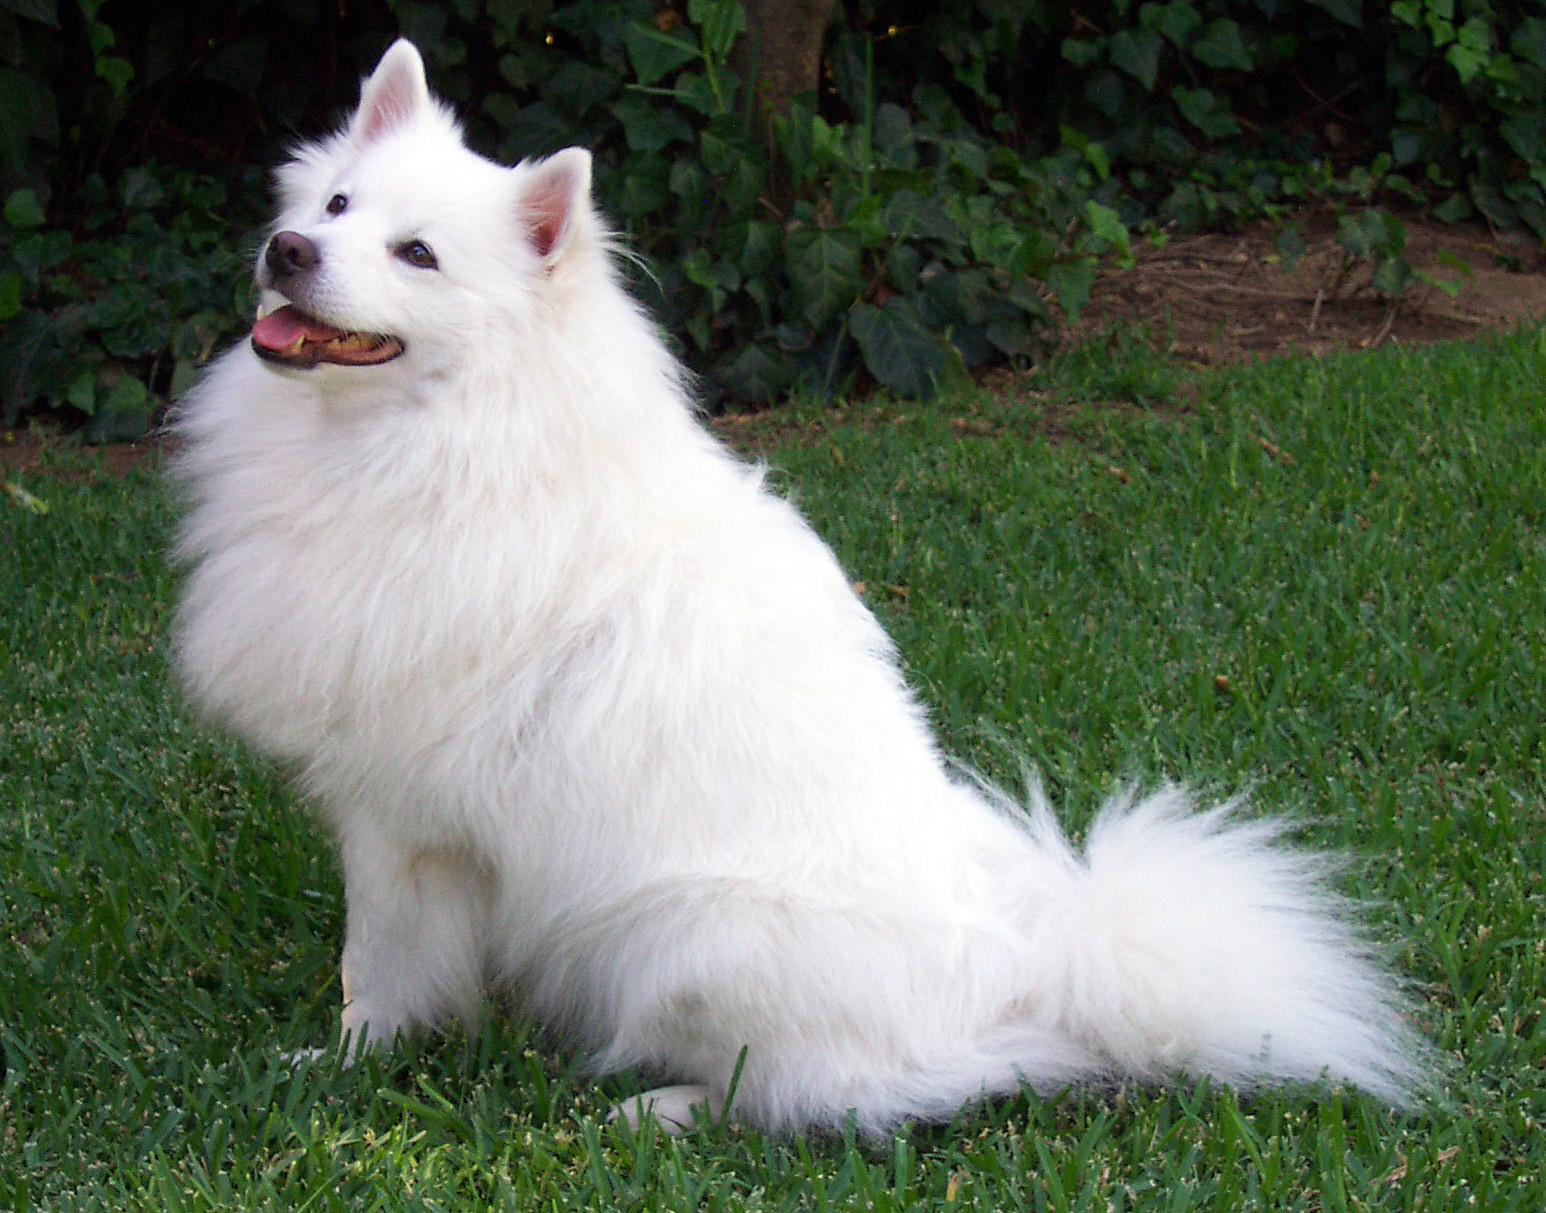

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('cat.jpg')
cv2_imshow(img)


#Pre-processing images before prediction
in deep learning prefers small value, from 0 to 1.Preprocessing tranform value RGB to small number for prediction.
We must convert to tensor data type before pass image to neural network

In [ ]:
filename = "/content/drive/MyDrive/mobilenetv2/facetraining/val/lisa/21419.jpg"

In [ ]:
# sample execution (requires torchvision)

from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

#Prediction

In [ ]:
with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
# print(output[0])
print(output[0][593])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities.size())

tensor(3.2551, device='cuda:0')
torch.Size([1000])


# download the list of class names

In [ ]:
# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2022-09-13 02:57:41--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0.001s  

2022-09-13 02:57:41 (10.4 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



# show the result
we get top 5 class have max values. From the ids we show the class names

In [ ]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
print('top 5 probality',top5_prob)
print('top 5 ids',top5_catid)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

top 5 probality tensor([0.4732, 0.4010, 0.1148, 0.0075, 0.0014], device='cuda:0')
top 5 ids tensor([281, 282, 285, 287, 622], device='cuda:0')
tabby 0.47315993905067444
tiger cat 0.4010397791862488
Egyptian cat 0.11483212560415268
lynx 0.0074902004562318325
lens cap 0.0014041804242879152


In [ ]:
%cd /content/drive/MyDrive/mobilenetv2

/content/drive/MyDrive/mobilenetv2


In [ ]:
import argparse
import torch
import os
import numpy as np
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torchvision import transforms, datasets
def train(input_path,data_transforms, model,batch_size,max_epochs, save_dir,start_epoch=0):
    best_train= 0
    best_lost = 100
   
    #create dataset from ImageFolder. the labels is the order of their corresponding folder
    image_datasets = {
        'train': 
        datasets.ImageFolder(input_path + 'train', data_transforms['train']),
        'validation': 
        datasets.ImageFolder(input_path + 'val', data_transforms['validation'])
    }
    #create dataloader to read batch_size of items for training
    #when training, images should be choose random, so shuffle = True
    dataloaders = {
        'train':
        torch.utils.data.DataLoader(image_datasets['train'],
                                    batch_size=batch_size,
                                    shuffle=True,
                                    num_workers=2),   # 1 if running on window
        'validation':
        torch.utils.data.DataLoader(image_datasets['validation'],
                                    batch_size=4,
                                    shuffle=False,
                                    num_workers=2)  # 1 if running on window
    }
    #change to cuda if the computer has vga
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
 
    criterion = nn.CrossEntropyLoss()
    # Observe that all parameters are being optimized
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.00004)
  
    for epoch in range(start_epoch,max_epochs):
        for phase in ['train', 'validation']:
                  if phase == 'train':
                      model.train() #switch to training mode
                  else:
                      model.eval()  #switch to evalutating mode

                  running_loss = 0.0
                  running_corrects = 0
                  it = 0
                  data_bar =  tqdm(dataloaders[phase])
                  for inputs, labels in data_bar:
                      inputs = inputs.to(device)
                      labels = labels.to(device)
                      outputs = model(inputs)
                      loss = criterion(outputs, labels)
                      if phase == 'train': #optimize the parameters if in training mode
                          optimizer.zero_grad()
                          loss.backward()
                          optimizer.step()
                      
                      _, preds = torch.max(outputs, 1)
                      running_loss += loss.item() * inputs.size(0)
                      running_corrects += torch.sum(preds == labels.data)
                      it = it + 1
                      data_bar.set_description('{} Epoch: [{}/{}] Loss: {:.8f} accuracy: {:.8f} '.format(phase , epoch,max_epochs, running_loss/(it * batch_size), running_corrects/(it * batch_size)))
                  #estimate average loss and accuracy of the epoch
                  epoch_loss = running_loss / len(image_datasets[phase])
                  epoch_acc = running_corrects.double() / len(image_datasets[phase])
                 #save the best weigth of model
                  if(phase == 'validation'):
                    if best_train < epoch_acc:
                        best_train = epoch_acc
                        filename = 'best.pth'
                        save_path = os.path.join(save_dir, filename)
                        torch.save(model.state_dict(), save_path)
                        print('-----> saved best accuracy at: ' , best_train)
                    if best_lost > epoch_loss:
                        best_lost = epoch_loss
                        filename = 'best_loss.pth'
                        save_path = os.path.join(save_dir, filename)
                        torch.save(model.state_dict(), save_path)
                        print('-----> saved best loss at: ' , best_lost)
               

In [ ]:
import torch.nn as nn
import torchvision.models as models
save_dir = '/content/drive/MyDrive/mobilenetv2/weights'
classnames=["jisoo","kimminju","lisa","rose"]
batch_size = 4
max_epochs = 50


trans_resize=transforms.Compose([
              transforms.Resize(256),
              transforms.RandomCrop(224),])
trans_aug = transforms.Compose([
              transforms.RandomChoice([
                 transforms.ColorJitter(brightness=(0.5, 0.7)),
                  transforms.ColorJitter(contrast=(0.5, 0.7)),
              transforms.RandomHorizontalFlip(),
              transforms.RandomRotation(90, expand=False),
              transforms.RandomGrayscale(p=1),]),
              transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
          ])

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
data_transforms = {
    'train':
    transforms.Compose([
        trans_resize,
        trans_aug,
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ]),
}
input_path = "/content/drive/MyDrive/mobilenetv2/facetraining/"

# Create mobilenet V2 model with pretrain. The weight will quickly be optimized

In [ ]:
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, len(classnames))

#Create Resnet50 model with pretrain. The weight will quickly be optimized
You just use one of the two model, or you can compare their performance

In [ ]:
model = models.resnet50(pretrained=True)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 4))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

# Call the train function to train the model

In [ ]:
train(input_path,data_transforms, model,  batch_size,max_epochs, save_dir,start_epoch=0)

train Epoch: [0/50] Loss: 1.21550933 accuracy: 0.48802397 : 100%|██████████| 167/167 [01:40<00:00,  1.67it/s]
validation Epoch: [0/50] Loss: 0.71415937 accuracy: 0.72727275 : 100%|██████████| 11/11 [00:03<00:00,  3.07it/s]


-----> saved best accuracy at:  tensor(0.7273, dtype=torch.float64)
-----> saved best loss at:  0.714159372177991


train Epoch: [1/50] Loss: 0.82957885 accuracy: 0.64970058 : 100%|██████████| 167/167 [01:44<00:00,  1.60it/s]
validation Epoch: [1/50] Loss: 1.01470382 accuracy: 0.79545456 : 100%|██████████| 11/11 [00:03<00:00,  2.88it/s]


-----> saved best accuracy at:  tensor(0.7955, dtype=torch.float64)


train Epoch: [2/50] Loss: 0.76919034 accuracy: 0.71706587 : 100%|██████████| 167/167 [01:40<00:00,  1.65it/s]
validation Epoch: [2/50] Loss: 0.81418017 accuracy: 0.84090906 : 100%|██████████| 11/11 [00:03<00:00,  3.48it/s]


-----> saved best accuracy at:  tensor(0.8409, dtype=torch.float64)


train Epoch: [3/50] Loss: 0.65465479 accuracy: 0.77245510 : 100%|██████████| 167/167 [01:41<00:00,  1.64it/s]
validation Epoch: [3/50] Loss: 0.70414621 accuracy: 0.81818181 : 100%|██████████| 11/11 [00:03<00:00,  3.42it/s]


-----> saved best loss at:  0.7041462083262476


train Epoch: [4/50] Loss: 0.80086460 accuracy: 0.70958084 : 100%|██████████| 167/167 [01:42<00:00,  1.63it/s]
validation Epoch: [4/50] Loss: 1.05051466 accuracy: 0.61363637 : 100%|██████████| 11/11 [00:03<00:00,  3.48it/s]
train Epoch: [5/50] Loss: 0.70793218 accuracy: 0.73652697 : 100%|██████████| 167/167 [01:40<00:00,  1.66it/s]
validation Epoch: [5/50] Loss: 0.41253002 accuracy: 0.88636363 : 100%|██████████| 11/11 [00:03<00:00,  3.51it/s]


-----> saved best accuracy at:  tensor(0.8864, dtype=torch.float64)
-----> saved best loss at:  0.4125300222393972


train Epoch: [6/50] Loss: 0.49010015 accuracy: 0.82335329 : 100%|██████████| 167/167 [01:41<00:00,  1.65it/s]
validation Epoch: [6/50] Loss: 0.48382545 accuracy: 0.79545456 : 100%|██████████| 11/11 [00:03<00:00,  3.50it/s]
train Epoch: [7/50] Loss: 0.58647289 accuracy: 0.79341316 : 100%|██████████| 167/167 [01:40<00:00,  1.65it/s]
validation Epoch: [7/50] Loss: 0.97339675 accuracy: 0.65909094 : 100%|██████████| 11/11 [00:03<00:00,  3.49it/s]
train Epoch: [8/50] Loss: 0.51545730 accuracy: 0.80688626 : 100%|██████████| 167/167 [01:41<00:00,  1.64it/s]
validation Epoch: [8/50] Loss: 0.34834815 accuracy: 0.90909094 : 100%|██████████| 11/11 [00:03<00:00,  3.53it/s]


-----> saved best accuracy at:  tensor(0.9091, dtype=torch.float64)
-----> saved best loss at:  0.34834815007211134


train Epoch: [9/50] Loss: 0.50054048 accuracy: 0.82784432 : 100%|██████████| 167/167 [01:41<00:00,  1.65it/s]
validation Epoch: [9/50] Loss: 0.42249764 accuracy: 0.88636363 : 100%|██████████| 11/11 [00:03<00:00,  3.44it/s]
train Epoch: [10/50] Loss: 0.51093400 accuracy: 0.81886226 : 100%|██████████| 167/167 [01:41<00:00,  1.65it/s]
validation Epoch: [10/50] Loss: 0.42273368 accuracy: 0.88636363 : 100%|██████████| 11/11 [00:03<00:00,  3.45it/s]
train Epoch: [11/50] Loss: 0.39795821 accuracy: 0.87425148 : 100%|██████████| 167/167 [01:41<00:00,  1.64it/s]
validation Epoch: [11/50] Loss: 0.63732783 accuracy: 0.81818181 : 100%|██████████| 11/11 [00:03<00:00,  3.43it/s]
train Epoch: [12/50] Loss: 0.35926275 accuracy: 0.87574852 : 100%|██████████| 167/167 [01:40<00:00,  1.66it/s]
validation Epoch: [12/50] Loss: 0.70122099 accuracy: 0.81818181 : 100%|██████████| 11/11 [00:03<00:00,  3.46it/s]
train Epoch: [13/50] Loss: 0.36196261 accuracy: 0.87574852 : 100%|██████████| 167/167 [01:41<00:00,  1

-----> saved best loss at:  0.3034984344174683


train Epoch: [14/50] Loss: 0.35174414 accuracy: 0.88772458 : 100%|██████████| 167/167 [01:41<00:00,  1.64it/s]
validation Epoch: [14/50] Loss: 0.24655530 accuracy: 0.93181819 : 100%|██████████| 11/11 [00:03<00:00,  3.43it/s]


-----> saved best accuracy at:  tensor(0.9318, dtype=torch.float64)
-----> saved best loss at:  0.24655529885521074


train Epoch: [15/50] Loss: 0.35755636 accuracy: 0.86227542 : 100%|██████████| 167/167 [01:40<00:00,  1.66it/s]
validation Epoch: [15/50] Loss: 0.34876980 accuracy: 0.88636363 : 100%|██████████| 11/11 [00:03<00:00,  3.52it/s]
train Epoch: [16/50] Loss: 0.36584378 accuracy: 0.86826348 : 100%|██████████| 167/167 [01:42<00:00,  1.63it/s]
validation Epoch: [16/50] Loss: 0.31328061 accuracy: 0.90909094 : 100%|██████████| 11/11 [00:03<00:00,  3.50it/s]
train Epoch: [17/50] Loss: 0.28019352 accuracy: 0.89970058 : 100%|██████████| 167/167 [01:41<00:00,  1.65it/s]
validation Epoch: [17/50] Loss: 0.22854964 accuracy: 0.90909094 : 100%|██████████| 11/11 [00:03<00:00,  3.45it/s]


-----> saved best loss at:  0.2285496366318708


train Epoch: [18/50] Loss: 0.35459465 accuracy: 0.86976045 : 100%|██████████| 167/167 [01:42<00:00,  1.63it/s]
validation Epoch: [18/50] Loss: 0.20711566 accuracy: 0.93181819 : 100%|██████████| 11/11 [00:03<00:00,  3.38it/s]


-----> saved best loss at:  0.20711566061601677


train Epoch: [19/50] Loss: 0.33712014 accuracy: 0.88173652 : 100%|██████████| 167/167 [01:40<00:00,  1.65it/s]
validation Epoch: [19/50] Loss: 0.22694384 accuracy: 0.88636363 : 100%|██████████| 11/11 [00:03<00:00,  3.29it/s]
train Epoch: [20/50] Loss: 0.31187517 accuracy: 0.90269458 : 100%|██████████| 167/167 [01:41<00:00,  1.64it/s]
validation Epoch: [20/50] Loss: 0.17255081 accuracy: 0.95454544 : 100%|██████████| 11/11 [00:03<00:00,  3.49it/s]


-----> saved best accuracy at:  tensor(0.9545, dtype=torch.float64)
-----> saved best loss at:  0.1725508087167162


train Epoch: [21/50] Loss: 0.29916748 accuracy: 0.91766465 : 100%|██████████| 167/167 [01:41<00:00,  1.64it/s]
validation Epoch: [21/50] Loss: 0.20961203 accuracy: 0.88636363 : 100%|██████████| 11/11 [00:03<00:00,  3.46it/s]
train Epoch: [22/50] Loss: 0.26528461 accuracy: 0.90868264 : 100%|██████████| 167/167 [01:40<00:00,  1.66it/s]
validation Epoch: [22/50] Loss: 0.07294345 accuracy: 1.00000000 : 100%|██████████| 11/11 [00:03<00:00,  3.44it/s]


-----> saved best accuracy at:  tensor(1., dtype=torch.float64)
-----> saved best loss at:  0.07294345269011418


train Epoch: [23/50] Loss: 0.32404096 accuracy: 0.89221555 : 100%|██████████| 167/167 [01:41<00:00,  1.64it/s]
validation Epoch: [23/50] Loss: 0.23629712 accuracy: 0.88636363 : 100%|██████████| 11/11 [00:03<00:00,  3.37it/s]
train Epoch: [24/50] Loss: 0.25790973 accuracy: 0.90868264 : 100%|██████████| 167/167 [01:40<00:00,  1.67it/s]
validation Epoch: [24/50] Loss: 0.17917498 accuracy: 0.93181819 : 100%|██████████| 11/11 [00:03<00:00,  3.48it/s]
train Epoch: [25/50] Loss: 0.22039141 accuracy: 0.92215568 : 100%|██████████| 167/167 [01:41<00:00,  1.64it/s]
validation Epoch: [25/50] Loss: 0.26512103 accuracy: 0.88636363 : 100%|██████████| 11/11 [00:03<00:00,  3.37it/s]
train Epoch: [26/50] Loss: 0.31714835 accuracy: 0.90568864 : 100%|██████████| 167/167 [01:43<00:00,  1.61it/s]
validation Epoch: [26/50] Loss: 0.21321271 accuracy: 0.93181819 : 100%|██████████| 11/11 [00:03<00:00,  3.48it/s]
train Epoch: [27/50] Loss: 0.26128679 accuracy: 0.90718561 : 100%|██████████| 167/167 [01:40<00:00, 

-----> saved best loss at:  0.06879749639384417


train Epoch: [35/50] Loss: 0.22782663 accuracy: 0.93113774 : 100%|██████████| 167/167 [01:57<00:00,  1.42it/s]
validation Epoch: [35/50] Loss: 0.17982578 accuracy: 0.90909094 : 100%|██████████| 11/11 [00:03<00:00,  3.47it/s]
train Epoch: [36/50] Loss: 0.21556626 accuracy: 0.93562877 : 100%|██████████| 167/167 [01:59<00:00,  1.40it/s]
validation Epoch: [36/50] Loss: 0.15381174 accuracy: 0.95454544 : 100%|██████████| 11/11 [00:03<00:00,  3.48it/s]
train Epoch: [37/50] Loss: 0.22024889 accuracy: 0.93263471 : 100%|██████████| 167/167 [01:43<00:00,  1.62it/s]
validation Epoch: [37/50] Loss: 0.38636181 accuracy: 0.90909094 : 100%|██████████| 11/11 [00:03<00:00,  3.43it/s]
train Epoch: [38/50] Loss: 0.19630024 accuracy: 0.94311374 : 100%|██████████| 167/167 [01:43<00:00,  1.61it/s]
validation Epoch: [38/50] Loss: 0.26223964 accuracy: 0.88636363 : 100%|██████████| 11/11 [00:03<00:00,  3.39it/s]
train Epoch: [39/50] Loss: 0.20969791 accuracy: 0.94461077 : 100%|██████████| 167/167 [01:40<00:00, 

-----> saved best loss at:  0.040419155766192656


train Epoch: [44/50] Loss: 0.14205284 accuracy: 0.95658684 : 100%|██████████| 167/167 [01:40<00:00,  1.66it/s]
validation Epoch: [44/50] Loss: 0.15576415 accuracy: 0.95454544 : 100%|██████████| 11/11 [00:03<00:00,  3.40it/s]
train Epoch: [45/50] Loss: 0.13971522 accuracy: 0.96257484 : 100%|██████████| 167/167 [01:45<00:00,  1.59it/s]
validation Epoch: [45/50] Loss: 0.07302225 accuracy: 0.95454544 : 100%|██████████| 11/11 [00:03<00:00,  3.45it/s]
train Epoch: [46/50] Loss: 0.14558062 accuracy: 0.94311374 : 100%|██████████| 167/167 [01:54<00:00,  1.46it/s]
validation Epoch: [46/50] Loss: 0.25525753 accuracy: 0.90909094 : 100%|██████████| 11/11 [00:04<00:00,  2.29it/s]
train Epoch: [47/50] Loss: 0.12318432 accuracy: 0.96107787 : 100%|██████████| 167/167 [01:51<00:00,  1.50it/s]
validation Epoch: [47/50] Loss: 0.13336922 accuracy: 0.95454544 : 100%|██████████| 11/11 [00:03<00:00,  3.41it/s]
train Epoch: [48/50] Loss: 0.09563214 accuracy: 0.96407187 : 100%|██████████| 167/167 [01:42<00:00, 

# Using the new model to predict the image 

Load the best weight

In [ ]:
filename = 'best.pth'
save_path = os.path.join(save_dir, filename)
if os.path.isfile(save_path):
    name, ext = os.path.splitext(save_path)
    assert ext == '.pkl' or '.pth', 'Sorry only .pth and .pkl files supported.'
    print('Resuming training, loading {}...'.format(save_path))
    print(model.load_state_dict(torch.load(save_path, map_location=lambda storage, loc: storage))   ) 


Resuming training, loading /content/drive/MyDrive/mobilenetv2/weights/best.pth...
<All keys matched successfully>


Read and show the image with link

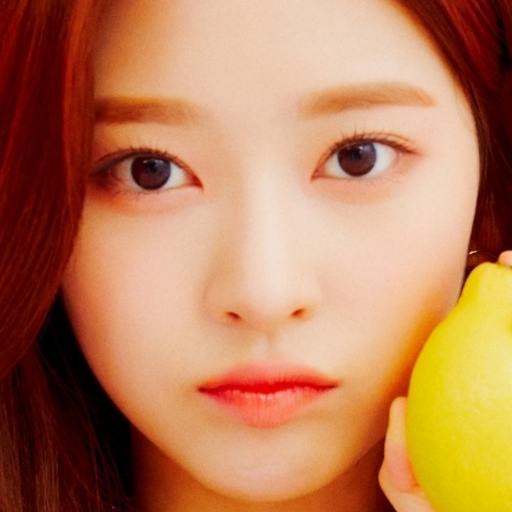

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
filename = "/content/drive/MyDrive/mobilenetv2/facetraining/val/kimminju/888.jpg"
img = cv2.imread(filename)
cv2_imshow(img)


Preprocess the image

In [ ]:

# Download an example image from the pytorch website
import urllib
url, filename = ("https://upload.wikimedia.org/wikipedia/commons/1/10/210928_Jisoo_%286%29.jpg", "jisoo.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread(filename)
cv2_imshow(img)

In [ ]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = data_transforms['validation'](input_image)
# input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

Classify the image

In [ ]:
model.eval()
with torch.no_grad():
    output = model(input_batch)
    _,preds = torch.max(output, 1)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output)
print(preds)
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)

tensor([[ 0.7005,  8.0773, -7.2802, -1.2598]])
tensor([1])
tensor([6.2512e-04, 9.9929e-01, 2.1379e-07, 8.8024e-05])


Show the result

In [ ]:
# Read the categories
classnames=["jisoo","kimminju","lisa","rose"]
# Show top categories per image
top2_prob, top2_catid = torch.topk(probabilities, 2)
print('top 2 probality',top2_prob)
print('top 2 ids',top2_catid)
for i in range(top2_prob.size(0)):
    print(classnames[top2_catid[i]], top2_prob[i].item())

top 2 probality tensor([9.9929e-01, 6.2512e-04])
top 2 ids tensor([1, 0])
kimminju 0.9992865920066833
jisoo 0.0006251190206967294


Classify a list of images

In [ ]:

validation_img_paths = ["val/jisu/7085.jpg",
                        "val/kimminju/888.jpg",
                        "val/lisa/20659.jpg",
                       "val/rose/15173.jpg"]
img_list = [Image.open(input_path + img_path) for img_path in validation_img_paths]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:

validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                for img in img_list])
pred_logits_tensor = model(validation_batch)

pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
print(pred_probs)
_,preds = torch.max(pred_logits_tensor, 1)
preds = preds.cpu().data.numpy()
print(preds)


[[9.9826556e-01 8.5162646e-06 8.2705334e-08 1.7257719e-03]
 [3.7623819e-02 9.4343513e-01 7.8702815e-06 1.8933237e-02]
 [1.0093155e-05 3.6750822e-05 9.9994993e-01 3.1897421e-06]
 [5.8367164e-06 2.2359841e-06 1.2103374e-05 9.9997985e-01]]
[0 1 2 3]


Show images in the list

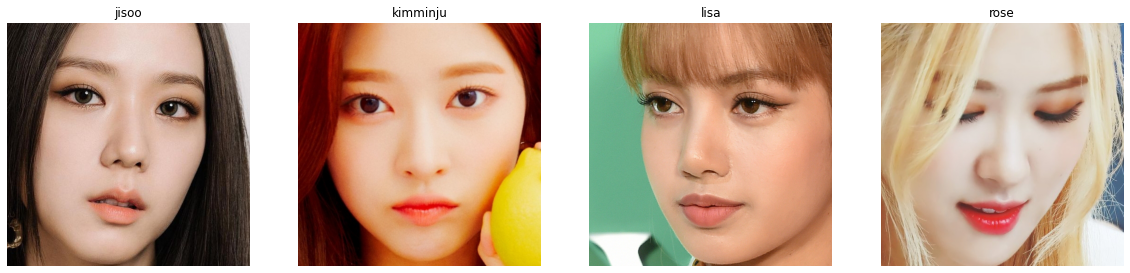

In [ ]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title( classnames[preds[i]])
    ax.imshow(img)

#  THis code show image in training dataset after using augmented techniques

torch.Size([3, 224, 224])


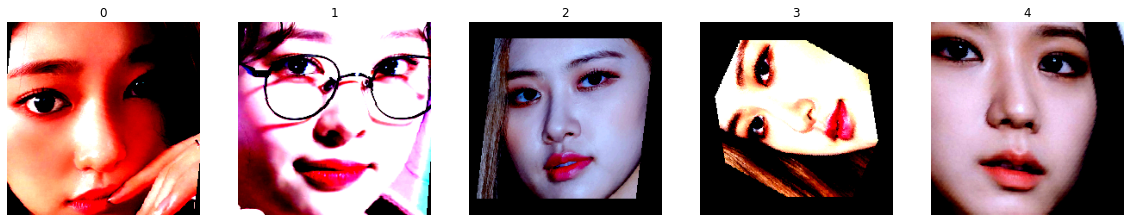

In [ ]:
import torchvision
import matplotlib.pyplot as plt

data_transforms = {
    'train':
    transforms.Compose([
        trans_resize,
        trans_aug,
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ]),
}
image_datasets = {
        'train': 
        datasets.ImageFolder(input_path + 'train', data_transforms['train']),
       
    }
 
dataloaders = {
        'train':
        torch.utils.data.DataLoader(image_datasets['validation'],
                                    batch_size=1,
                                    shuffle=True,
                                    num_workers=1)  # 1 if running on window
    }

data=iter(dataloaders['train'])
print(data.next()[0].squeeze().size())
i = 0
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
while i < 5:
  img = data.next()[0].squeeze()
  npimg=img.numpy()
  ax = axs[i]
  ax.axis('off')
  ax.set_title( str(i))
  ax.imshow(np.transpose(npimg,(1,2,0)))
  i+= 1